# k-Nearest Neighbors

## Imports and Seed

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

Getting seed

In [118]:
with open("seed.txt", "r") as f:
    my_seed = int(f.read().strip())

print(f"Seed: {my_seed}")

Seed: 3356680259


getting the student dataset from q1

In [119]:
class StudentDataset:
    def __init__(self,num_students:int,seed:int):
        self.rng = np.random.default_rng(seed)
        self.total = num_students
        self.df = self.assemble_dataframe()

    def get_full_dataframe(self):
        return self.df #getter?

    def assemble_dataframe(self):
        df = pd.DataFrame({"id": range(1, self.total + 1)})
        df["gender"] = self.generate_gender()
        df["major"] = self.generate_major()
        df["program"] = self.generate_program(df["major"].tolist())
        df["GPA"] = self.generate_gpa(df["major"].tolist())
        return df
    
    def generate_gender(self):
        gender_list = []
        rng = self.rng
        for _ in range(self.total):
            r = rng.random()
            if r < 0.65:
                gender_list.append("Male")
            elif r < 0.65 + 0.33:
                gender_list.append("Female")
            else:
                gender_list.append("Other")
        return gender_list

    def generate_major(self):
        major_list = []
        rng = self.rng
        for _ in range(self.total):
            r = rng.random()
            if r < 0.7:
                major_list.append("B.Tech")
            elif r < 0.7 + 0.2:
                major_list.append("MS")
            else:
                major_list.append("PhD")
        return major_list
    
    def generate_program(self,majors:list[str]):
        program_list = []
        rng = self.rng

        for major in majors:
            if major == "B.Tech":
                program_list.append(rng.choice(["CSE", "ECE", "CHD", "CND"],p=[0.4,0.4,0.1,0.1]))
            elif major == "MS":
                program_list.append(rng.choice(["CSE", "ECE", "CHD", "CND"],p=[0.3,0.3,0.2,0.2]))
            else:
                program_list.append(rng.choice(["CSE", "ECE", "CHD", "CND"])) ## all are same nahi likhuga ;)
        return program_list
    
    def generate_gpa(self,majors:list[str]):
        gpa_list = []
        rng = self.rng
        for major in majors:
            if major == "B.Tech":
                val = rng.normal(7.0,1.0)
            elif major == "MS":
                val = rng.normal(8.0,0.7)
            else:
                val = rng.normal(8.3,0.5)
            val = np.clip(val,4.0,10.0)
            gpa_list.append(val)
        return gpa_list 

In [120]:
stud_obj = StudentDataset(num_students=1000, seed=my_seed)
df = stud_obj.get_full_dataframe()
df.head()

,id,gender,major,program,GPA
0,1,Male,B.Tech,CHD,8.357746
1,2,Female,B.Tech,CSE,8.132740
2,3,Male,B.Tech,CSE,5.031619
3,4,Male,B.Tech,CHD,6.611947
4,5,Male,B.Tech,ECE,8.287342


In [121]:
class PerFeatureTransformer:
    def __init__(self):
        self.transformers = {}

    def fit(self, df: pd.DataFrame, params: dict[str, str]) -> None:
        self.feature_order = list(params.keys())   
        for col, t_type in params.items():
            if t_type == "standard":
                transformer = StandardScaler()
                transformer.fit(df[[col]])
            elif t_type == "ordinal":
                categories = [sorted(df[col].dropna().unique().tolist())]
                transformer = OrdinalEncoder(categories=categories)
                transformer.fit(df[[col]])
            elif t_type == "onehot":
                print(f"col is {col}")
                transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
                transformer.fit(df[[col]])
            self.transformers[col] = (t_type, transformer)

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        arrays = []
        for col, (t_type, transformer) in self.transformers.items():
            arr = transformer.transform(df[[col]])
            # print(f"ttype : {t_type},shape : {arr.shape}")
            arrays.append(arr)
        return np.hstack(arrays)

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        self.fit(df, params)
        return self.transform(df)

In [122]:
class KNNGenderPredictor:
    def __init__(self, student_df: pd.DataFrame, username: str):
        """ Initializes the predictor with the full student dataset .
Use the username for plots . """
        self.student_df = student_df
        self.username = username
        self.feature_transformer = PerFeatureTransformer()
        self.X_train = None
        self.y_train = None

    def _add_watermark(self, ax):
        """Helper to add watermark to a plot."""
        ax.text(0.95, 0.95, self.username,
                ha='right', va='top',
                transform=ax.transAxes,
                fontsize=10, color='gray', alpha=0.7)
        
    def train_val_test_split(self, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42):
        # First split: separate test set (20%)
        train_val_df, test_df = train_test_split(self.student_df, test_size=test_size, stratify=self.student_df['gender'], random_state=seed)
        train_df, val_df = train_test_split(train_val_df, test_size=val_size/(1-test_size), stratify=train_val_df['gender'], random_state=seed)
        return (train_df, val_df, test_df)

    def get_feature_matrix_and_labels ( self , df : pd . DataFrame ,features : list [ str ], flag : bool = False) -> tuple [ np . ndarray , np . ndarray ]:
        """
        Extract selected features and gender labels from the
        DataFrame .        train_df,val_df,_ = self.train_val_test_split(test_size=0.2,val_size=0.2,seed = my_seed)

        Applies encoding to categorical variables and normalizes
        numeric features . Do not fit encoders or scalers on test
        data . Only transform using previously fitted ones .
        """
        # X = df[features]
        params = {}
        for col in features:
            if col == "GPA":
                params["GPA"] = "standard"
            elif col == "major":
                params["major"] = "ordinal"
            elif col == "program":
                params["program"] = "onehot"
        if flag:
            X_arr = self.feature_transformer.fit_transform(df[features], params)
            self.X_train = X_arr
            self.y_train = df['gender'].values
        else:
            if self.feature_transformer is None:
                raise ValueError("Transformer not fitted. Call with flag=True first.")
            X_arr = self.feature_transformer.transform(df[features])
        y = df['gender'].values

        return (X_arr, y)

    def get_knn_accuracy_vs_k ( self , k_values : list [ int ] , features : list [ str ] , distance :str = "euclidean") -> list [ float ]:
        """ Calculates accuracy scores for various k values on the`
        validation set . """
        train_df,val_df,_ = self.train_val_test_split(test_size=0.2,val_size=0.2,seed = my_seed)
        if self.X_train is None or self.y_train is None:
            print(f"Training data not found. Shapes are {train_df.shape}, {val_df.shape}")
            self.get_feature_matrix_and_labels(train_df, features, flag=True)
        X_val, y_val = self.get_feature_matrix_and_labels(val_df, features, flag=False)
        accuracies = []
        print(f"distance: {distance}")
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
            knn.fit(self.X_train, self.y_train)
            accuracies.append(knn.score(X_val, y_val))
        return accuracies   

    def plot_knn_accuracy_vs_k ( self , k_values : list [ int ] ,  features : list [ str ] ,distance :str = "euclidean") :
        """ Plots accuracy scores against k values on the validation
        set . """
        accuracies = self.get_knn_accuracy_vs_k(k_values, features, distance)
        print(f"The accuracies are {accuracies}")
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=k_values, y=accuracies, marker='o')
        plt.title(f'KNN Accuracy vs K (Distance: {distance})')
        plt.xlabel('Number of Neighbors (K)')
        plt.ylabel('Accuracy')
        plt.xticks(k_values)
        plt.grid()
        self._add_watermark(plt.gca())
        plt.show()
        ## return the k with which we had max accuracy
        max_k = k_values[np.argmax(accuracies)]
        return (max_k,max(accuracies))

    def get_knn_f1_heatmap ( self , k_values : list [ int ] , features : list [ str ] , distances :list [ str ]) -> pd . DataFrame :
        """ Returns a dataframe with the f1 - score for each
        combination on the validation set """
        train_df,val_df,_ = self.train_val_test_split(test_size=0.2,val_size=0.2,seed = my_seed)
        X_train, y_train = self.get_feature_matrix_and_labels(train_df, features, flag=True)    
        X_val, y_val = self.get_feature_matrix_and_labels(val_df, features, flag=False)
        # if self.X_train is None or self.y_train is None:
        #     self.get_feature_matrix_and_labels(train_df, features, flag=True)
        f1_scores_df = pd.DataFrame(index=k_values, columns=distances)
        for k in k_values:
            for dist in distances:
                knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_val)
                f1_scores_df.loc[k, dist] = f1_score(y_val, y_pred, average='weighted')
        return f1_scores_df

    def plot_knn_f1_heatmap ( self , f1_scores_df : pd . DataFrame ) -> None :
        f1_scores_df = f1_scores_df.astype(float)
        plt.figure(figsize=(12, 8))
        sns.heatmap(f1_scores_df, annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("KNN F1 Score Heatmap")
        plt.xlabel("Distance Metric")
        plt.ylabel("Number of Neighbors (K)")
        self._add_watermark(plt.gca())
        plt.show()

    def get_knn_f1_single_feature_table(self,k_values : list[int],features : list[str],distance  : str = "euclidean")->pd.DataFrame:
        """ Creates a table of F1 scores on the test set using only a
        single feature for prediction . """
        train_df,_,test_df = self.train_val_test_split(test_size=0.2,val_size=0.2,seed = my_seed)
        # if self.X_train is None or self.y_train is None:
        #     self.get_feature_matrix_and_labels(train_df, features, flag=True)
        X_train, y_train = self.get_feature_matrix_and_labels(train_df, features, flag=True)
        X_test_all, y_test = self.get_feature_matrix_and_labels(test_df, features, flag=False)

        f1_scores = pd.DataFrame(index=features, columns=k_values)
        for feature in features:
            feature_idx = features.index(feature)
            X_train_single = X_train[:, feature_idx].reshape(-1, 1)
            X_test_single = X_test_all[:, feature_idx].reshape(-1, 1)

            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k,metric=distance)
                knn.fit(X_train_single, y_train)
                y_pred = knn.predict(X_test_single)
                f1 = f1_score(y_test, y_pred, average='weighted')
                f1_scores.loc[feature, k] = f1
        return f1_scores


In [123]:
Knn_obj = KNNGenderPredictor(df, "nidhish.jain")

In [124]:
train, val, test = Knn_obj.train_val_test_split(test_size=0.2, val_size=0.2, seed=my_seed)
print(f"shapes are {train.shape}, {test.shape}, {val.shape}")
train.head()
print(train['gender'].value_counts(normalize=True))

shapes are (600, 5), (200, 5), (200, 5)
gender
Male      0.656667
Female    0.321667
Other     0.021667
Name: proportion, dtype: float64


In [125]:
## applying transform

train_arr = Knn_obj.get_feature_matrix_and_labels(train, ["GPA", "major", "program"],flag=True)
print(train_arr[0][:4])
print(train_arr[1][:4])

col is program
[[-0.57910385  0.          0.          0.          1.          0.        ]
 [-0.19790083  0.          0.          0.          0.          1.        ]
 [-0.06044905  0.          0.          0.          0.          1.        ]
 [ 0.07750539  0.          0.          0.          1.          0.        ]]
['Female' 'Female' 'Male' 'Male']


In [126]:
test_arr = Knn_obj.get_feature_matrix_and_labels(test, ["GPA", "major", "program"], flag=False)
print(test_arr[0][:4])
print(test_arr[1][:4])

[[ 0.96732017  2.          0.          1.          0.          0.        ]
 [ 0.40702192  1.          1.          0.          0.          0.        ]
 [-0.83936624  0.          0.          0.          1.          0.        ]
 [ 0.91963542  1.          0.          0.          1.          0.        ]]
['Male' 'Male' 'Female' 'Male']


In [127]:
val_arr = Knn_obj.get_feature_matrix_and_labels(val, ["GPA", "major", "program"], flag=False)
print(val_arr[0][:4])
print(val_arr[1][:4])

[[0.98812929 1.         0.         0.         0.         1.        ]
 [1.98056928 0.         0.         0.         0.         1.        ]
 [0.18439971 0.         0.         1.         0.         0.        ]
 [1.69895945 0.         0.         0.         0.         1.        ]]
['Male' 'Male' 'Female' 'Female']


distance: euclidean


The accuracies are [0.52, 0.54, 0.58, 0.635, 0.65, 0.635, 0.645, 0.63, 0.66, 0.645, 0.64]


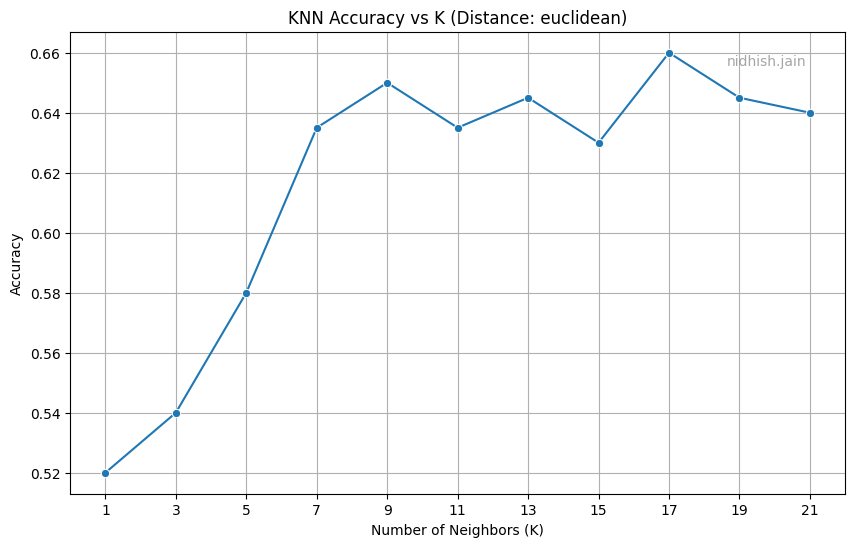

max accuracy at k = 17 and accuracy is 0.66


In [128]:
k_val = []
for i in range(1,22):
    if i % 2 == 1:
        k_val.append(i)
max_k,max_acc = Knn_obj.plot_knn_accuracy_vs_k(k_values=k_val, features=["GPA", "major", "program"],distance="euclidean")
print(f"max accuracy at k = {max_k} and accuracy is {max_acc}")

distance: manhattan
The accuracies are [0.52, 0.54, 0.58, 0.635, 0.65, 0.64, 0.64, 0.63, 0.665, 0.65, 0.645]


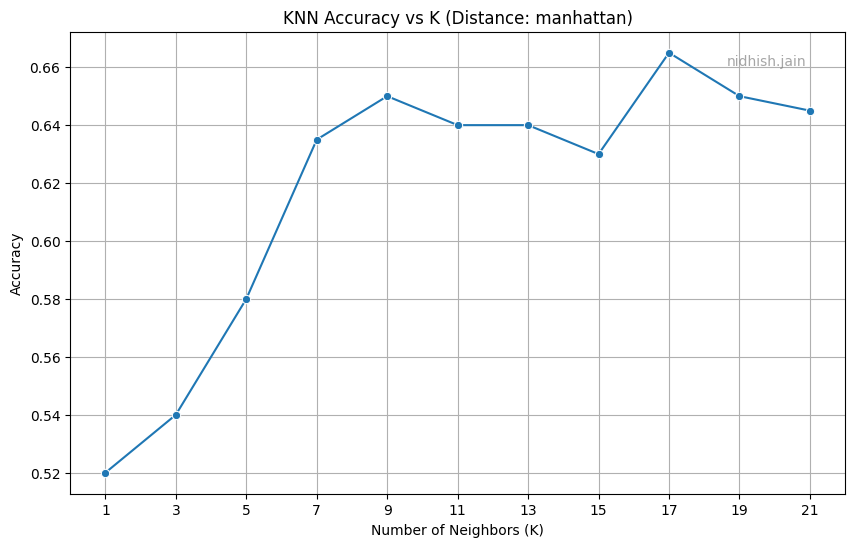

max accuracy at k = 17 and accuracy is 0.665


In [129]:
k_val = []
for i in range(1,22):
    if i % 2 == 1:
        k_val.append(i)
max_k,max_acc = Knn_obj.plot_knn_accuracy_vs_k(k_values=k_val, features=["GPA", "major", "program"],distance="manhattan")
print(f"max accuracy at k = {max_k} and accuracy is {max_acc}")


distance: cosine
The accuracies are [0.515, 0.54, 0.57, 0.615, 0.63, 0.64, 0.655, 0.645, 0.67, 0.66, 0.65]


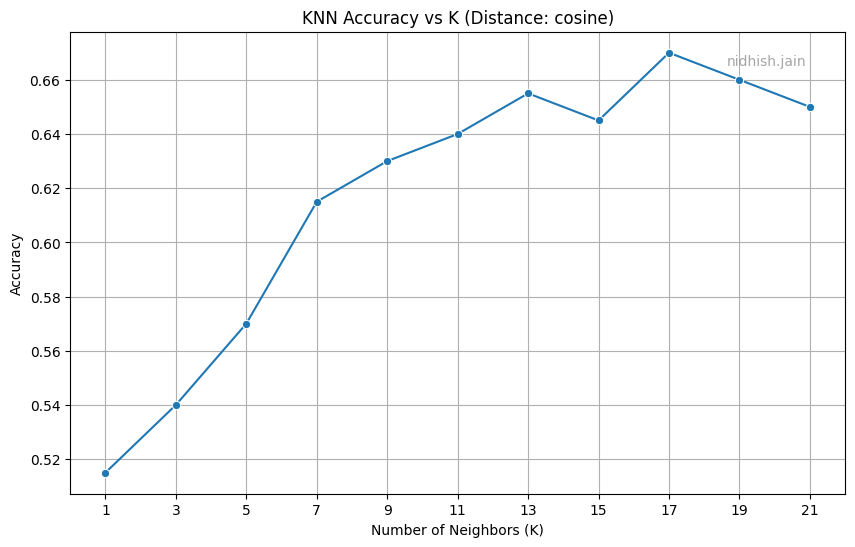

max accuracy at k = 17 and accuracy is 0.67


In [130]:
k_val = []
for i in range(1,22):
    if i % 2 == 1:
        k_val.append(i)
max_k,max_acc = Knn_obj.plot_knn_accuracy_vs_k(k_values=k_val,features=["GPA","major","program"],distance="cosine")
print(f"max accuracy at k = {max_k} and accuracy is {max_acc}")

In [131]:
f1_heat_df = Knn_obj.get_knn_f1_heatmap(k_values=k_val, features=["GPA", "major", "program"], distances=["euclidean", "manhattan", "cosine"])
### have to print all 
print(f1_heat_df)
### print k and col which has max
print(f1_heat_df.stack().idxmax())

col is program
   euclidean manhattan    cosine
1   0.528933  0.528933  0.523524
3   0.528455  0.528455  0.528455
5   0.559662  0.559662  0.546723
7   0.601876  0.601876  0.577231
9   0.606661  0.606661  0.588283
11  0.575817  0.579272  0.574556
13    0.5675  0.564263  0.573975
15  0.533901  0.533901  0.555743
17  0.558164  0.561111  0.564056
19  0.535185  0.537905  0.558164
21  0.524829  0.527425  0.544074
(9, 'euclidean')


In [132]:
print(f1_heat_df.stack().idxmax())
print(f1_heat_df.max().max())

(9, 'euclidean')
0.6066613798572562


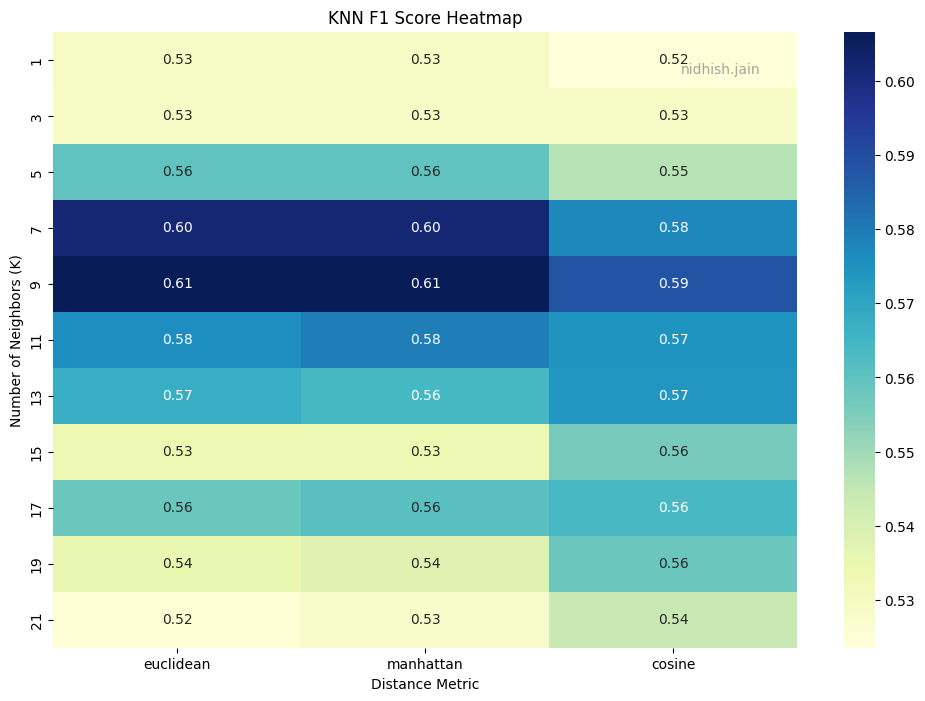

In [133]:
Knn_obj.plot_knn_f1_heatmap(f1_heat_df)

### Which distance metric performs better? 

The issue with my seed is that there are some variations in train/validation set and I get way different results and for different n we get different results for the given config we are having almost same results. Although here euclidean performs a bit better.

But in reality it should be the cosine metric that is more appropriate for this type of data. Reason being that the features are not continuous in nature and are categorical. So the distance between two categories is not defined. Since we are defining it based on our convinience they might not capture the true similarity between instances. So if we use angle of similarity between two vectors then we can use KNN and get correct results.

Infact when I check accuracy we get the best accuracy when we used cosine similarity.

ALso with different values of n in dataset point generation we get different result so we cannot rely on a single split for evaluation.

In [134]:
features= ["GPA", "major", "program"]
sing_feat_df_euc = Knn_obj.get_knn_f1_single_feature_table(features=features, distance="euclidean",k_values=[1,3,5,7,9,11,13,15,17,19,21])

col is program


In [135]:
### the best performance? feature name and k
print(sing_feat_df_euc.max().max())
best_feature = sing_feat_df_euc.stack().idxmax()
print(best_feature)

0.5625822663635276
('GPA', 3)


In [136]:
sing_feat_df_man = Knn_obj.get_knn_f1_single_feature_table(features=features, distance="manhattan",k_values=[1,3,5,7,9,11,13,15,17,19,21])

col is program


In [137]:
print(sing_feat_df_man.max().max())
best_feature = sing_feat_df_man.stack().idxmax()
print(best_feature)

0.5625822663635276
('GPA', 3)


In [138]:
sing_feat_df_cos = Knn_obj.get_knn_f1_single_feature_table(features=features, distance="cosine",k_values=[1,3,5,7,9,11,13,15,17,19,21])

col is program


In [139]:
print(sing_feat_df_cos.max().max())
best_feature = sing_feat_df_cos.stack().idxmax()
print(best_feature)

0.5315382113821139
('GPA', 1)


The single feature which performed best for this is GPA and with accuracy nearing 0.56.

It is clear that the f1 score has reduced for the case when we are using single features compared to using all features. The reason for this can be that the features that we are using are not independent and there is some correlation between them. So when we use all features we are able to capture the correlation between them and get better results. But when we use single feature we are not able to capture the correlation and hence the performance is reduced.

Along with that each other feature do include information about gender which might be missed out resulting in lower f1 score when used in single feature mode.